In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# modified from test.ipynb and main.py

import time
from utils import plot_3d_boundary, plot_3d_observed_rewards
from pylab import *
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition

# Constraints
from emukit.core.constraints import LinearInequalityConstraint

In [3]:
# Libraries for multiprocessing
from multiprocess.pool import Pool
from tqdm.auto import tqdm

In [4]:
from loop import *

## miniSCOT Functions

In [5]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336*1,
        'num_batteries': int(x[0])
    }

    if len(x) == 2:
        kwargs.update({
            #'max_battery_capacity': int(x[1])
            'battery_penalty': int(x[1])
        })

    if len(x) == 3:
        kwargs.update({
            'max_battery_capacity': int(x[1]),
             #'time_horizon': int(x[2])
            'battery_penalty': int(x[2])
        })
    if len(x) == 4:
        kwargs.update({
            'max_battery_capacity': int(x[1]),
            'time_horizon': int(x[2]),
            'battery_penalty': int(x[3])
        })

    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]

In [6]:
def f(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    Y = []
    for x in X:
        cum_reward = invoke_miniscot(x)

        # Note that we negate the reward; want to find min
        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [7]:
def f_multiprocess(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs using multiprocessing.

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    
    # Set to None to use all available CPU
    max_pool = 5
    with Pool(max_pool) as p:
        Y = list(
            tqdm(
                p.imap(invoke_miniscot, X),
                total=X.shape[0]
            )
        )

    # Note that we negate the reward; want to find min
    Y = -np.reshape(np.array(Y), (-1, 1))
    return Y

## Plotting Functions

In [8]:
def plot_reward(X, Y, labels):
    """
    Plots reward against a maximum of two dimensions.
    """

    plt.style.use('seaborn')
    fig = plt.figure(figsize=(12, 12))

    order = np.argsort(X[:,0])
    
    if X.shape[1] == 1:
        ax = plt.axes()
        ax.plot(X[order,0], Y[order])
        ax.set_xlabel(labels[0])
        ax.set_ylabel("Cumulative reward")
    elif X.shape[1] == 2:
        ax = plt.axes(projection='3d')
        im = ax.plot_trisurf(X[order,0].flatten(), X[order,1].flatten(), Y[order].flatten(), cmap=cm.get_cmap('autumn'))
        fig.colorbar(im)
        ax.view_init(90, 90)
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel("Cumulative reward")  # (£/MWh)
    else:
        raise ValueError('X has too many dimensions to plot - max 2 allowed')

    return fig, ax

# First, 1D Core Experiments

## Num Batteries

In [9]:
from scse.default_run_parameters.national_grid_default_run_parameters import DEFAULT_RUN_PARAMETERS

In [10]:
max_num_batteries = 1000

num_data_points = 10

timesteps_per_week = 336
num_weeks = 52
time_horizon_value = timesteps_per_week*1

min_time_horizon_value = timesteps_per_week * 1
max_time_horizon_value = timesteps_per_week * 2

num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
#max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1))
#battery_penalty = DiscreteParameter(
#    'battery_penalty', range(min_battery_penalty, max_battery_penalty+1))
time_horizon = DiscreteParameter('time_horizon', range(min_time_horizon_value, max_time_horizon_value+1))

#parameters = [num_batteries, max_battery_capacities, time_horizon, battery_penalty]
parameters = [num_batteries]
parameter_space = ParameterSpace(parameters)

In [11]:
# Check the parameters of the intial values (X)

design = RandomDesign(parameter_space)
X = design.get_samples(num_data_points)
X

array([[604],
       [381],
       [ 21],
       [876],
       [780],
       [647],
       [804],
       [633],
       [223],
       [855]])

In [12]:
design = RandomDesign(parameter_space)

# Get initial data points
X = design.get_samples(num_data_points)
start = time.time()
Y = f_multiprocess(X)
end = time.time()
print("Getting {} initial simulation points took {} seconds".format(
    num_data_points, round(end - start, 0)))

  0%|          | 0/10 [00:00<?, ?it/s]

Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:


KeyboardInterrupt: 

In [ ]:
plot_reward(X, Y, parameter_space.parameter_names)

CURRENT ATTEMPT #0


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.stopping_conditions:Stopped as consecutive evaluations are within 0.01
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.loop.outer_loop:Finished outer loop


successfully ran loop


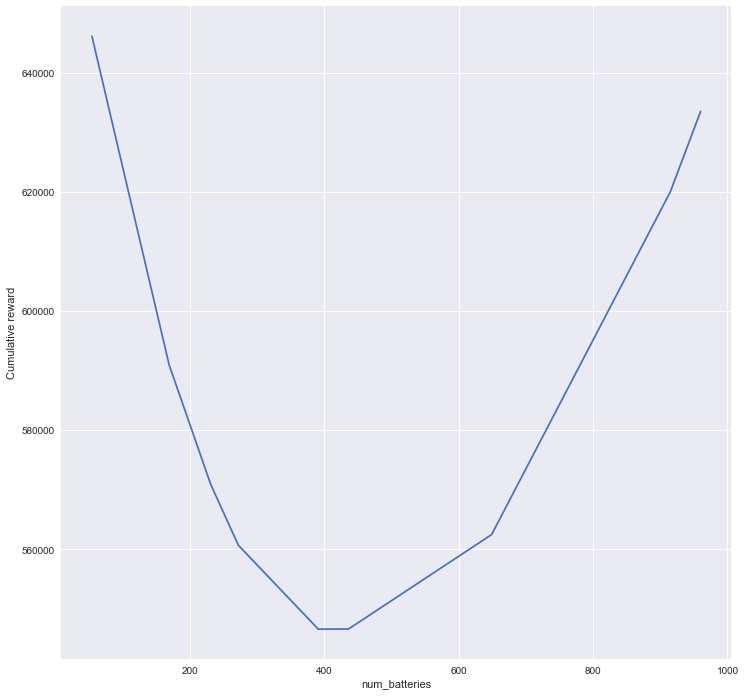

In [70]:
successful_sample = False
num_tries = 0
max_num_tries = 3

use_default= False
use_ard=False

while not successful_sample and num_tries < max_num_tries: 
    
    print(f"CURRENT ATTEMPT #{num_tries}")
    
    # emulator model

    if use_default: 
        gpy_model = GPRegression(X, Y)
    else: 
        kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
        gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
    
    try: 
        gpy_model.optimize()
        print("okay to optimize")
        model_emukit = GPyModelWrapper(gpy_model)

        # Load core elements for Bayesian optimization
        expected_improvement = ExpectedImprovement(model=model_emukit)
        optimizer = GradientAcquisitionOptimizer(space=parameter_space)

        # Create the Bayesian optimization object
        batch_size = 3
        bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                 space=parameter_space,
                                                 acquisition=expected_improvement,
                                                 batch_size=batch_size)

        # Run the loop and extract the optimum;  we either complete 10 steps or converge
        max_iters = 10
        stopping_condition = (
            FixedIterationsStoppingCondition(i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)
        )

        bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
        print("successfully ran loop")
        successful_sample = True
        
    except: 
        num_tries += 1 


In [71]:
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

new_order = np.argsort(new_X[:,0])
new_X = new_X[new_order,:]
new_Y = new_Y[new_order]

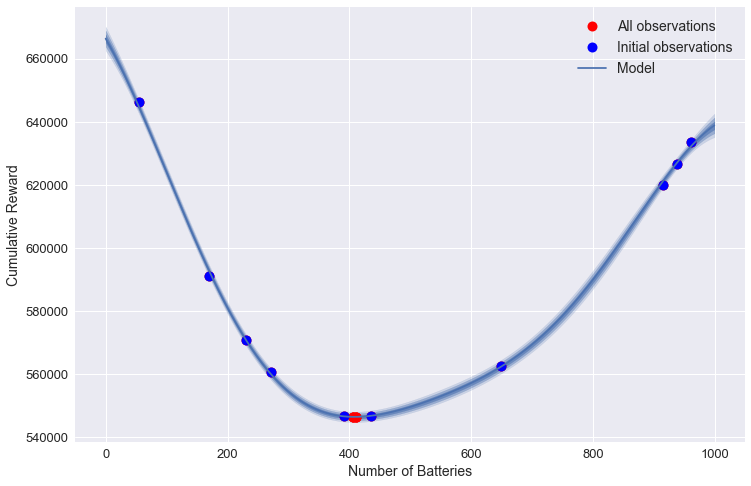

In [93]:
x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
mu_plot, var_plot = model_emukit.predict(x_plot)

plt.figure(figsize=(12, 8))
#plt.figure(figsize=(7, 5))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(prop={'size': 14})
plt.xlabel("Number of Batteries", fontsize=14)
plt.ylabel("Cumulative Reward", fontsize=14)
plt.grid(True)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

# Next, 2D Experiments

## Num Batteries + Max Battery Penalty

In [11]:
from scse.default_run_parameters.national_grid_default_run_parameters import DEFAULT_RUN_PARAMETERS

In [12]:
max_num_batteries = 1000

# units in £/
min_battery_penalty = DEFAULT_RUN_PARAMETERS.battery_penalty - 100000
max_battery_penalty = DEFAULT_RUN_PARAMETERS.battery_penalty + 200000

num_data_points = 20

timesteps_per_week = 336
num_weeks = 52
time_horizon_value = timesteps_per_week*1

min_time_horizon_value = timesteps_per_week * 1
max_time_horizon_value = timesteps_per_week * 2

num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
battery_penalty = DiscreteParameter(
    'battery_penalty', range(min_battery_penalty, max_battery_penalty+1))
time_horizon = DiscreteParameter('time_horizon', range(min_time_horizon_value, max_time_horizon_value+1))

#parameters = [num_batteries, max_battery_capacities, time_horizon, battery_penalty]
parameters = [num_batteries, battery_penalty]
parameter_space = ParameterSpace(parameters)

In [13]:
# Check the parameters of the intial values (X)

design = RandomDesign(parameter_space)
X = design.get_samples(num_data_points)
X

array([[    365, -271900],
       [     30,  -96066],
       [    719, -252345],
       [    219, -238142],
       [    879,  -21633],
       [    913,  -68606],
       [    527,  -60775],
       [     90, -284178],
       [    101, -110261],
       [    458, -260207],
       [    528, -226128],
       [    775, -243276],
       [    887, -140601],
       [    886, -233487],
       [    173, -142809],
       [    307,  -74631],
       [    856, -132403],
       [    663, -268149],
       [    441,  -77593],
       [    146, -229651]])

In [14]:
design = RandomDesign(parameter_space)

# Get initial data points
X = design.get_samples(num_data_points)
start = time.time()
Y = f_multiprocess(X)
end = time.time()
print("Getting {} initial simulation points took {} seconds".format(
    num_data_points, round(end - start, 0)))

  0%|          | 0/20 [00:00<?, ?it/s]

Getting 20 initial simulation points took 140.0 seconds


(<Figure size 864x864 with 2 Axes>,
 <Axes3DSubplot:xlabel='num_batteries', ylabel='battery_penalty'>)

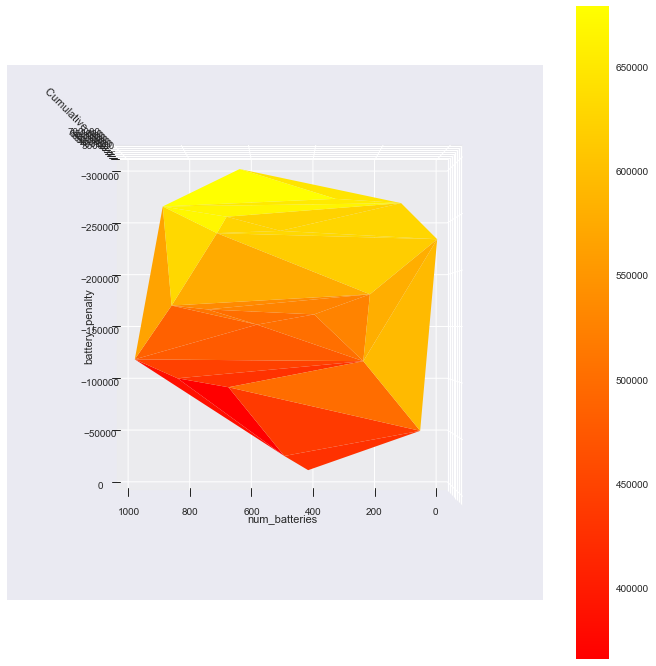

In [15]:
plot_reward(X, Y, parameter_space.parameter_names)

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


GP_regression.,value,constraints,priors
sum.rbf.variance,74614.77821991453,+ve,"Ga(1e+03, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(1e+03, 10)"
sum.bias.variance,78776.44515085474,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |     priors    
  [0]    |                       555.35825061  |      +ve      |  Ga(1e+03, 10)
  [1]    |                       555.33602908  |      +ve      |  Ga(1e+03, 10)


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.outer_loop:Iteration 2
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.outer_loop:Iteration 3
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.outer_loop:Iteration 4
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.outer_loop:Iteration 5
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.stopping_conditions:Stopped as consecutive evaluations are within 0.01
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.loop.outer_loop:Finished outer loop


Successfully ran loop


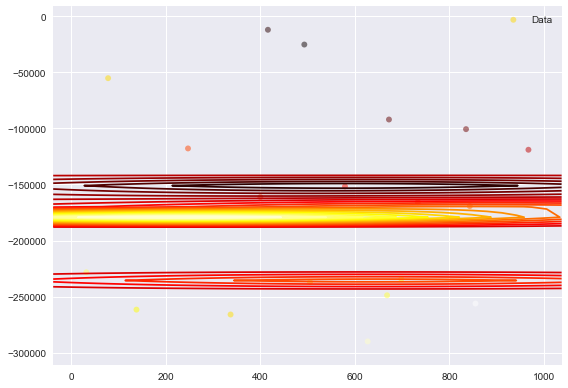

In [16]:
# Kernel Specification; specify active dimensions
kr = GPy.kern.RBF(input_dim=X.shape[1], active_dims=[0,1], ARD=True)  # exclude time dim
kb = GPy.kern.Bias(input_dim=X.shape[1], active_dims=[0,1])
kernel = kr+kb

# Some prior distributions for model parameters
v_prior = GPy.priors.Gamma.from_EV(100, 10.)
l_prior = GPy.priors.Gamma.from_EV(100, 10.)

# Some prior distributions for model parameters
gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
gpy_model.kern.rbf.variance.set_prior(v_prior)
gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
gpy_model.Gaussian_noise.variance.constrain_fixed()



successful_sample = False
num_tries = 0
max_num_tries = 1

while not successful_sample and num_tries < max_num_tries: 
    
    #print(f"CURRENT ATTEMPT #{num_tries}")
    
    try:

        #gpy_model.optimize()
        gpy_model.optimize_restarts(
            num_restarts=10, robust=False, verbose=False, messages=False)

        # Logging GP fit
        _ = gpy_model.plot(visible_dims=[0,1])
        display(gpy_model)
        print(gpy_model.kern.rbf.lengthscale)

        model_emukit = GPyModelWrapper(gpy_model)

        # ======== Run BO to acquire points but also fit GP =========

        # Choose acquisition function
        ei_acq = ExpectedImprovement(model_emukit)
        acq_func = ei_acq

        # Load core elements for Bayesian optimization
        optimizer = GradientAcquisitionOptimizer(space=parameter_space)

        # Create the Bayesian optimization object
        batch_size = 3
        bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                space=parameter_space,
                                                acquisition=acq_func,
                                                batch_size=batch_size)

        # Run the loop and extract the optimum;  we either complete 10 steps or converge
        max_iters = 10
        epsilon = 0.01
        stopping_condition = (FixedIterationsStoppingCondition(
            i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

        start = time.time()
        bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
        end = time.time()
        print("Successfully ran loop")
        successful_sample = True

    except: 
        num_tries += 1 

(<Figure size 864x864 with 2 Axes>,
 <Axes3DSubplot:xlabel='num_batteries', ylabel='battery_penalty'>)

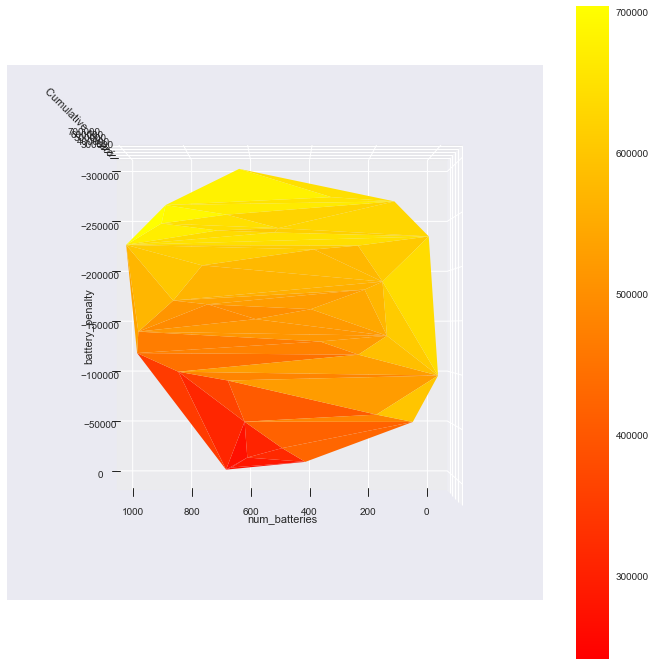

In [18]:
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

new_order = np.argsort(new_X[:,0])
new_X = new_X[new_order,:]
new_Y = new_Y[new_order]
plot_reward(new_X, new_Y, parameter_space.parameter_names)

[[119252.48667746]
 [118530.70195076]
 [117758.62461708]
 ...
 [123755.87013868]
 [123715.23834372]
 [123681.06383968]]


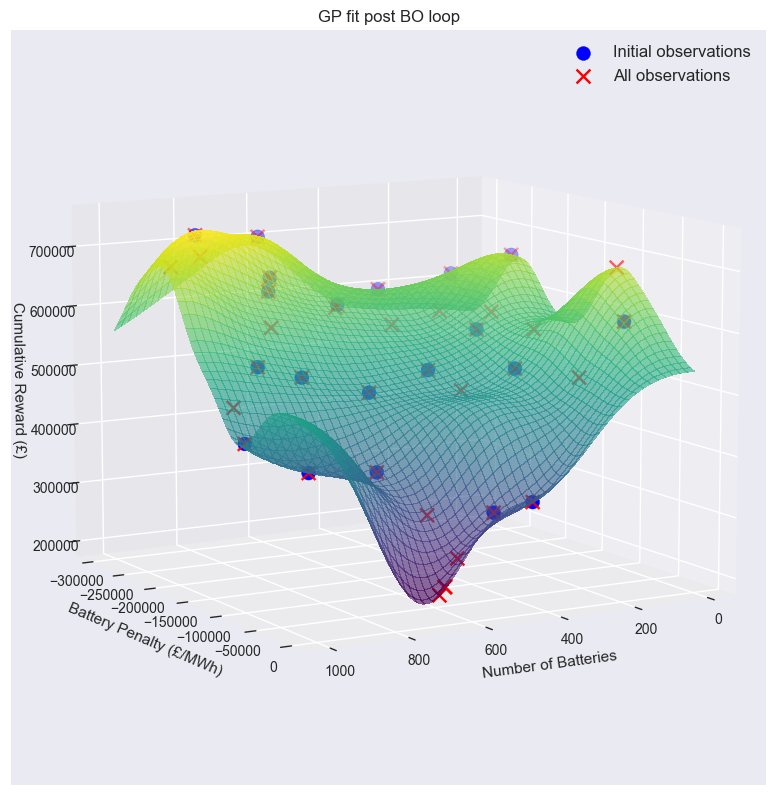

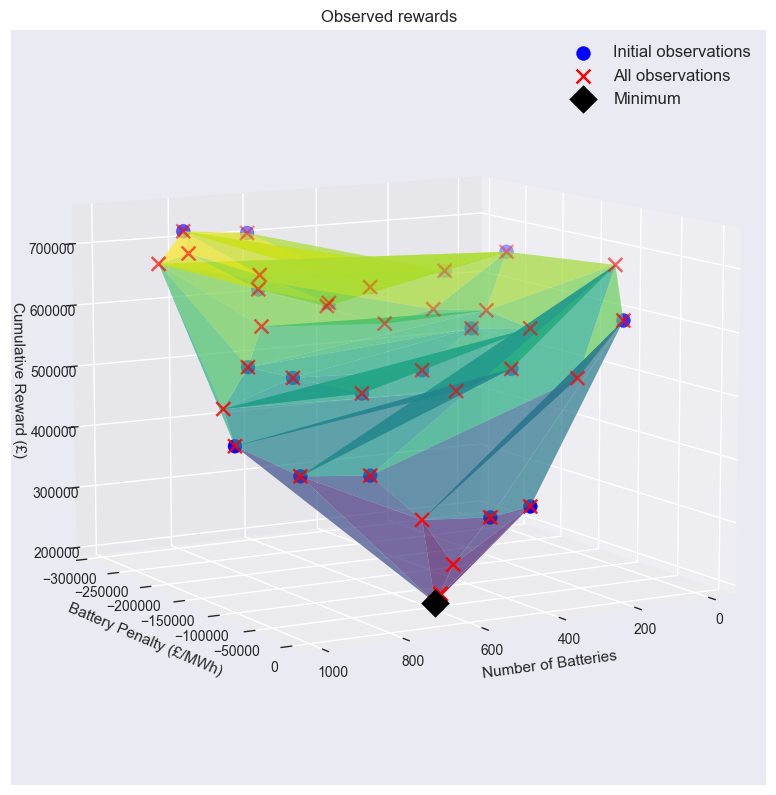

In [28]:
# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_penalty:max_battery_penalty:1000]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

mu_plot, var_plot = model_emukit.predict(positions_with_time)
kwargs = {
    'X': X,
    'Y': Y,
    'plot_new': True,
    'new_X': new_X,
    'new_Y': new_Y,
    'mesh_X': mesh_X,
    'mesh_Y': mesh_Y,
    'mu_plot': mu_plot,
    'var_plot': var_plot,
    'title': "GP fit post BO loop",
    'plot_ci': False,
    'elev': 10,
    'angle': 60,
    'dim1': max_num_batteries,
    'dim2': 300,
    #'save_fig_path': "img_1"
}
fig, ax = plot_3d_boundary(**kwargs)
print(var_plot)

kwargs = {
    'X': X,
    'Y': Y,
    'plot_new': True,
    'new_X': new_X,
    'new_Y': new_Y,
    'elev': 10,
    'angle': 60,
    'title': "Observed rewards",
    'save_fig_path': ""
}
fig, ax = plot_3d_observed_rewards(**kwargs)

## Playing with plotting, without having to restart the kernel

In [26]:
def plot_3d_observed_rewards(X, Y,
                             elev,
                             angle,
                             z_lims=None,
                             plot_new=None,
                             new_X=None,
                             new_Y=None,
                             title=None,
                             dpi=100,
                             save_fig_path=None):
    
    plt.rcParams['xtick.major.pad']='1'
    plt.rcParams['ytick.major.pad']='1'

    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = plt.axes(projection='3d')

    ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
               s=100, marker="o", color="b", label="Initial observations")

    if plot_new:
        im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
        ), new_Y.flatten(), cmap='viridis', alpha=0.70)

        ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
                   new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

        min_X = new_X[np.argmin(new_Y)]
        min_Y = np.min(new_Y)
        ax.scatter(min_X[0], min_X[1], min_Y, c='black',
                   marker='D', label="Minimum", s=200)
    else:
        im = ax.plot_trisurf(X[:, 0].flatten(), X[:, 1].flatten(
        ), Y.flatten(), cmap='viridis', alpha=0.70)

    ax.legend(loc=1, prop={'size': 12})
    ax.set_xlabel("Number of Batteries")
    ax.set_ylabel("Battery Penalty (£/MWh)")
    ax.set_zlabel("Cumulative Reward (£)")

    ax.view_init(elev=elev, azim=angle)

    if z_lims:
        ax.set_zlim(z_lims)

    ax.grid(True)
    if title == None:
        plt.title("Contour of observed rewards")
    else:
        plt.title(title)

    if save_fig_path:
        for theta in range(0, 360, 10):
            ax.view_init(elev=elev, azim=theta)
            plt.savefig(save_fig_path+"_{}.png".format(theta))

    return fig, ax

In [27]:
def plot_3d_boundary(X, Y, mesh_X, mesh_Y,
                     mu_plot, var_plot,
                     elev,
                     angle,
                     z_lims=None,
                     plot_new=False,
                     new_X=None,
                     new_Y=None,
                     dpi=100,
                     plot_ci=True,
                     title=None,
                     save_fig_path=None,
                     dim1=1000,
                     dim2=21):

    plt.rcParams['xtick.major.pad']='1'
    plt.rcParams['ytick.major.pad']='1'
    
    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape(
        (dim1, dim2)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.60)

    if plot_ci:
        surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot-var_plot).reshape(
            (dim1, dim2)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)
        surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot+var_plot).reshape(
            (dim1, dim2)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)

    ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
               s=100, marker="o", color="b", label="Initial observations")

    if plot_new:
        ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
                   new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

    ax.grid(True)
    ax.set_xlabel("Number of Batteries")
    ax.set_ylabel("Battery Penalty (£/MWh)")
    ax.set_zlabel("Cumulative Reward (£)")

    if z_lims:
        ax.set_zlim(z_lims)

    if title:
        plt.title(title)
    plt.legend(loc='upper right', prop={'size': 12})

    if save_fig_path:
        for theta in range(0, 360, 10):
            ax.view_init(elev=elev, azim=theta)
            plt.savefig(save_fig_path+"_{}.png".format(theta))

    ax.view_init(elev=elev, azim=angle)
    return fig, ax

## Varying max battery capacity and number batteries

In [10]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336*1,
        'num_batteries': int(x[0])
    }

    if len(x) == 2:
        kwargs.update({
            'max_battery_capacity': int(x[1])
        })
        
    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]

In [11]:
max_num_batteries = 100
min_battery_capacity = 1
max_battery_capacity = 40

# units in £/
min_battery_penalty = DEFAULT_RUN_PARAMETERS.battery_penalty - 100000
max_battery_penalty = DEFAULT_RUN_PARAMETERS.battery_penalty + 200000

num_data_points = 10

timesteps_per_week = 336
num_weeks = 52
time_horizon_value = timesteps_per_week*1

min_time_horizon_value = timesteps_per_week * 1
max_time_horizon_value = timesteps_per_week * 2

num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', np.linspace(min_battery_capacity, max_battery_capacity+1, 101))
battery_penalty = DiscreteParameter(
    'battery_penalty', range(min_battery_penalty, max_battery_penalty+1))
time_horizon = DiscreteParameter('time_horizon', range(min_time_horizon_value, max_time_horizon_value+1))

#parameters = [num_batteries, max_battery_capacities, time_horizon, battery_penalty]
parameters = [num_batteries, max_battery_capacities]
parameter_space = ParameterSpace(parameters)

In [12]:
# Check the parameters of the intial values (X)

design = RandomDesign(parameter_space)
X = design.get_samples(num_data_points)
#X = np.array([[800., 1.],[600., 1.5], [400., 2.], [200., 4.], [100., 8.], [50., 16.], [25., 32.], [10., 80.], [1, 0.1], [1,1], [2, 1], [1,0.5]])
X

array([[90. , 22.2],
       [93. ,  5. ],
       [10. , 40.2],
       [54. , 11.4],
       [ 3. , 33.4],
       [71. ,  7.4],
       [89. , 40.6],
       [31. , 22.6],
       [35. , 25.8],
       [50. , 29.8]])

In [ ]:
design = RandomDesign(parameter_space)

# Get initial data points
start = time.time()
Y = f_multiprocess(X)
end = time.time()
print("Getting {} initial simulation points took {} seconds".format(
    num_data_points, round(end - start, 0)))

(<Figure size 864x864 with 2 Axes>,
 <Axes3DSubplot:xlabel='num_batteries', ylabel='max_battery_capacity'>)

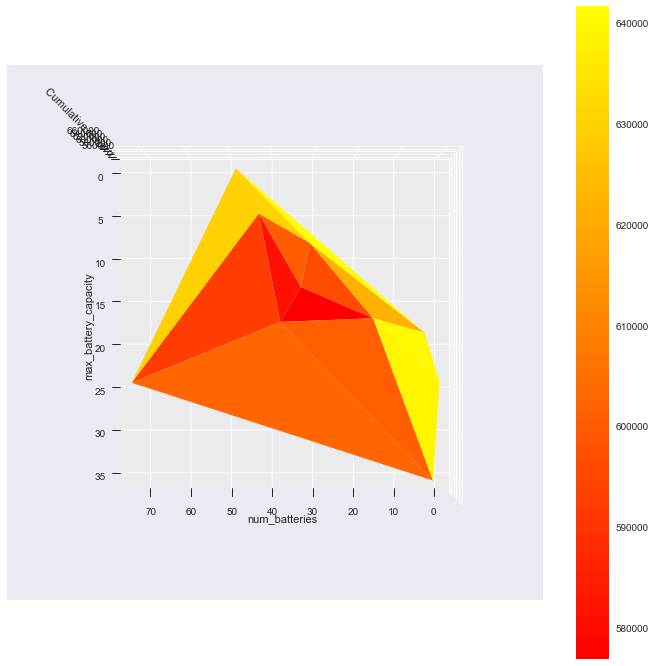

In [42]:
plot_reward(X, Y, parameter_space.parameter_names)

In [13]:
Y = np.load('Y.npy')
X = np.load('X.npy')
X[1,:] = [28., 28.]

In [ ]:
# Kernel Specification; specify active dimensions
kr = GPy.kern.RBF(input_dim=X.shape[1], active_dims=[0,1], ARD=True)  # exclude time dim
kb = GPy.kern.Bias(input_dim=X.shape[1], active_dims=[0,1])
kernel = kr+kb

# Some prior distributions for model parameters
v_prior = GPy.priors.Gamma.from_EV(1000, 100.)
l_prior = GPy.priors.Gamma.from_EV(100, 1000.)

# Some prior distributions for model parameters
gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
gpy_model.kern.rbf.variance.set_prior(v_prior)
gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
gpy_model.Gaussian_noise.variance.constrain_fixed()



successful_sample = False
num_tries = 0
max_num_tries = 1

while not successful_sample and num_tries < max_num_tries: 
    
    #print(f"CURRENT ATTEMPT #{num_tries}")
    
    try:

        #gpy_model.optimize()
        gpy_model.optimize_restarts(
            num_restarts=10, robust=False, verbose=False, messages=False)

        # Logging GP fit
        _ = gpy_model.plot(visible_dims=[0,1])
        display(gpy_model)
        print(gpy_model.kern.rbf.lengthscale)

        model_emukit = GPyModelWrapper(gpy_model)

        # ======== Run BO to acquire points but also fit GP =========

        # Choose acquisition function
        ei_acq = ExpectedImprovement(model_emukit)
        acq_func = ei_acq

        # Load core elements for Bayesian optimization
        optimizer = GradientAcquisitionOptimizer(space=parameter_space)

        # Create the Bayesian optimization object
        batch_size = 3
        bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                space=parameter_space,
                                                acquisition=acq_func,
                                                batch_size=batch_size)

        # Run the loop and extract the optimum;  we either complete 10 steps or converge
        max_iters = 10
        epsilon = 0.01
        stopping_condition = (FixedIterationsStoppingCondition(
            i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

        start = time.time()
        bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
        end = time.time()
        print("Successfully ran loop")
        successful_sample = True

    except: 
        num_tries += 1 

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


GP_regression.,value,constraints,priors
sum.rbf.variance,85767.20707417701,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,172304971.8992504,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                        15.72127180  |      +ve      |  Ga(10, 0.1)
  [1]    |                         6.04306406  |      +ve      |  Ga(10, 0.1)


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

new_order = np.argsort(new_X[:,0])
new_X = new_X[new_order,:]
new_Y = new_Y[new_order]
plot_reward(new_X, new_Y, parameter_space.parameter_names)

NameError: name 'bayesopt_loop' is not defined

### Save model data

In [89]:
# Save model
results = bayesopt_loop.get_results()
config_res = {}
config_res['model'] = gpy_model.to_dict()
config_res['best_reward'] = (results.minimum_location, results.minimum_value)
config_res['num_data_points'] = num_data_points # number of initial data points
config_res['num_eval_points'] = num_eval_points # num of BO points evaluated
config_res['batch_size'] = batch_size
config_res['max_iters'] = max_iters
config_res['epsilon'] = epsilon
config_res['eval_iters'] = num_eval_points//batch_size
config_res['eval_time'] = round(end-start, 0)
config_res['mu_plot'] = mu_plot
config_res['var_plot'] = var_plot
np.save('exp', config_res)

NameError: name 'num_eval_points' is not defined

In [ ]:
print(parameter_space.parameter_names)
for days in all_results.keys():
    min_X, min_Y = all_results[days]['best_reward']
    print(min_X, end='\t')
    print(min_X[2]/48, end='\t')
    print(round(min_Y))

In [28]:
# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:0.1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

mu_plot, var_plot = model_emukit.predict(positions_with_time)
kwargs = {
    'X': X,
    'Y': Y,
    'plot_new': True,
    'new_X': new_X,
    'new_Y': new_Y,
    'mesh_X': mesh_X,
    'mesh_Y': mesh_Y,
    'mu_plot': mu_plot,
    'var_plot': var_plot,
    'title': "GP fit post BO loop",
    'plot_ci': False,
    'elev': 20,
    'angle': 315,
    'dim1': max_num_batteries,
    'dim2': max_battery_capacity*10,
    #'save_fig_path': "img_1"
}
fig, ax = plot_3d_boundary(**kwargs)
print(var_plot)

kwargs = {
    'X': X,
    'Y': Y,
    'plot_new': True,
    'new_X': new_X,
    'new_Y': new_Y,
    'elev': 20,
    'angle': 315,
    'title': "Observed rewards",
    'save_fig_path': ""
}
fig, ax = plot_3d_observed_rewards(**kwargs)

NameError: name 'time_horizon_value' is not defined